In [2]:
pip install kagglehub

Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install numpy

Note: you may need to restart the kernel to use updated packages.


In [4]:
pip install pandas

Note: you may need to restart the kernel to use updated packages.


In [5]:
pip install matplotlib

Note: you may need to restart the kernel to use updated packages.


In [6]:
pip install seaborn

Note: you may need to restart the kernel to use updated packages.


In [7]:
pip install idx2numpy

Note: you may need to restart the kernel to use updated packages.


In [8]:
!pip install tensorflow

  Using cached tensorflow-2.18.0-cp312-cp312-macosx_12_0_arm64.whl.metadata (4.0 kB)
  Using cached absl_py-2.1.0-py3-none-any.whl.metadata (2.3 kB)
  Using cached astunparse-1.6.3-py2.py3-none-any.whl.metadata (4.4 kB)
  Using cached flatbuffers-25.1.24-py2.py3-none-any.whl.metadata (875 bytes)
  Using cached gast-0.6.0-py3-none-any.whl.metadata (1.3 kB)
  Using cached google_pasta-0.2.0-py3-none-any.whl.metadata (814 bytes)
  Using cached libclang-18.1.1-1-py2.py3-none-macosx_11_0_arm64.whl.metadata (5.2 kB)
  Using cached opt_einsum-3.4.0-py3-none-any.whl.metadata (6.3 kB)
  Using cached termcolor-2.5.0-py3-none-any.whl.metadata (6.1 kB)
  Using cached wrapt-1.17.2-cp312-cp312-macosx_11_0_arm64.whl.metadata (6.4 kB)
  Using cached grpcio-1.70.0-cp312-cp312-macosx_10_14_universal2.whl.metadata (3.9 kB)
  Using cached tensorboard-2.18.0-py3-none-any.whl.metadata (1.6 kB)
  Using cached keras-3.8.0-py3-none-any.whl.metadata (5.8 kB)
  Using cached wheel-0.45.1-py3-none-any.whl.metadata

In [29]:
import numpy as np
import pandas as pd
import idx2numpy
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import os
import kagglehub
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import confusion_matrix, classification_report


In [10]:

# Download latest version
path = kagglehub.dataset_download("hojjatk/mnist-dataset")

print("Path to dataset files:", path)

100%|██████████| 22.0M/22.0M [00:00<00:00, 50.1MB/s]

Extracting files...


Path to dataset files: /Users/juliayelvington/.cache/kagglehub/datasets/hojjatk/mnist-dataset/versions/1


## MNIST Handwritten Digits Supervised Learning Project
This project is a supervised learning project that uses a neural network to classify images of handwritten digits.

The dataset used is the MNIST dataset, which contains 60,000 training images and 10,000 test images of handwritten digits.

The neural network used is a simple feedforward neural network and is trained using the Adam optimizer.

In [41]:
# Function to load MNIST data
def load_mnist(path, kind='train'):
    """Download mnist from kaggle"""
    labels_path = os.path.join(path, f"{kind}-labels.idx1-ubyte")
    images_path = os.path.join(path, f"{kind}-images.idx3-ubyte")

    with open(labels_path, "rb") as lbpath:
        labels = idx2numpy.convert_from_file(labels_path)
        # print(labels)

    with open(images_path, 'rb') as imgpath:
        images = idx2numpy.convert_from_file(imgpath).reshape(len(labels), 28 * 28)
        # print(images)

        
    return images / 255.0, labels  # normalize [0,1]

In [12]:
# Load Data and Check Shape
data_path = "mnist-dataset/versions/1"
X_train, y_train = load_mnist(data_path, kind='train')
X_test, y_test = load_mnist(data_path, kind='t10k')

print(f"Train shape: {X_train.shape}, Test shape: {X_test.shape}")
print(f"Test shape: {y_train.shape}")

Train shape: (60000, 784), Test shape: (10000, 784)
Test shape: (60000,)


### Exploratory Data Analysis

In [13]:
# Create DataFrames
pixel_columns = [f'pixel{i}' for i in range(X_train.shape[1])]
train_df = pd.DataFrame(X_train, columns=pixel_columns)
train_df['label'] = y_train

pixel_columns = [f'pixel{i}' for i in range(X_test.shape[1])]
test_df = pd.DataFrame(X_test, columns=pixel_columns)
test_df['label'] = y_test

In [14]:
# Ensure no missing values
print("\nMissing values in training set:")
print(train_df.isnull().sum().any())


Missing values in training set:
False


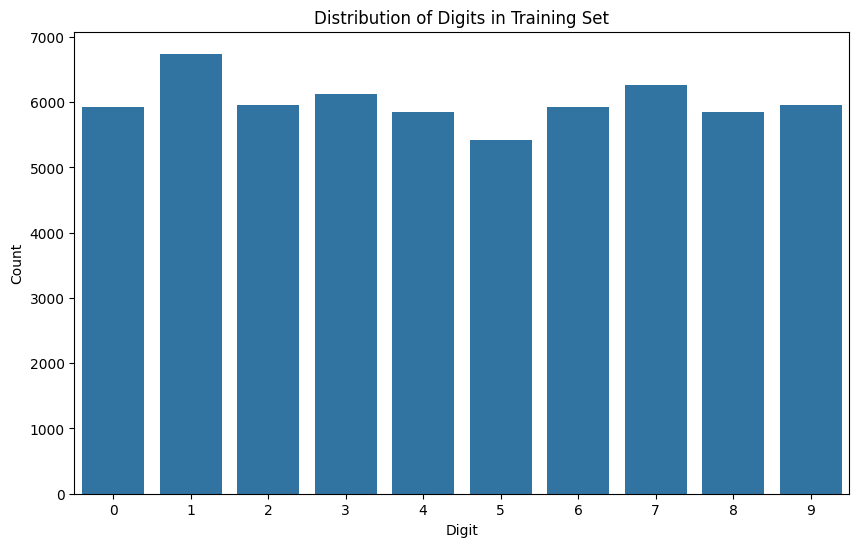

In [15]:
# Distribution of Digits
plt.figure(figsize=(10, 6))
sns.countplot(data=train_df, x='label')
plt.title('Distribution of Digits in Training Set')
plt.xlabel('Digit')
plt.ylabel('Count')
plt.show()

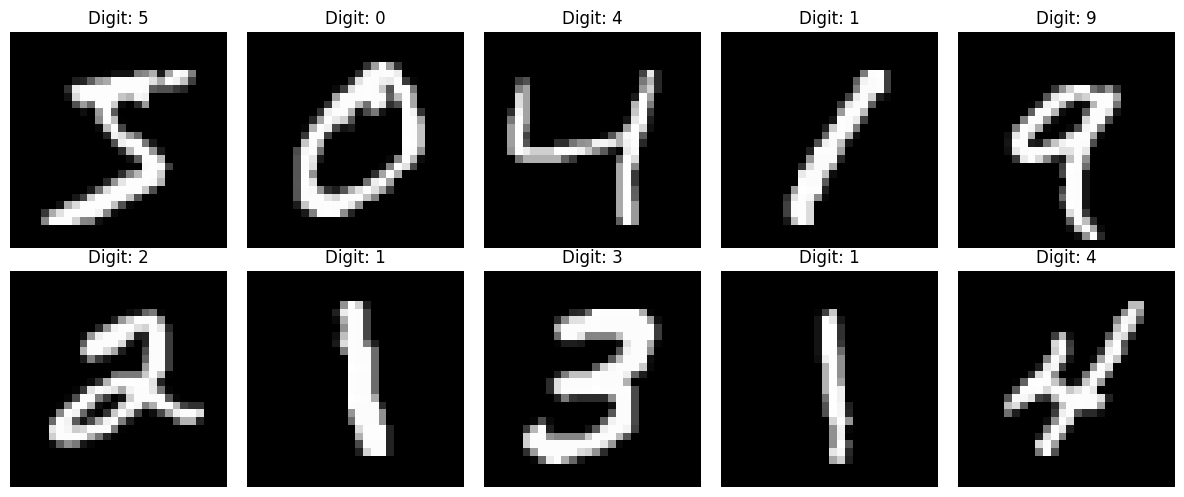

In [16]:
# Sample Digits
fig, axes = plt.subplots(2, 5, figsize=(12, 5))
for i, ax in enumerate(axes.flat):
    img = train_df.iloc[i, :-1].values.reshape(28, 28)  # Exclude label column
    ax.imshow(img, cmap='gray')
    ax.set_title(f'Digit: {train_df.iloc[i, -1]}')
    ax.axis('off')
plt.tight_layout()
plt.show()

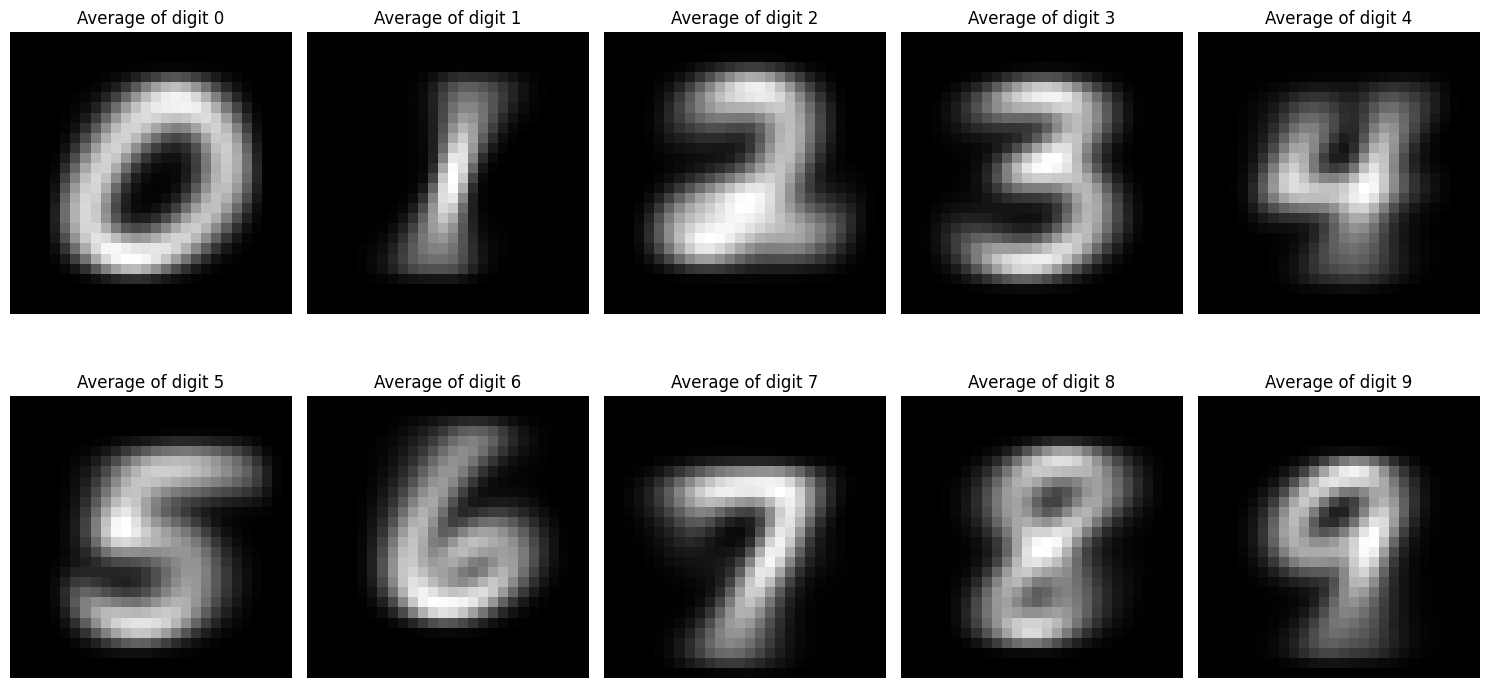

In [17]:
# Average Digits
plt.figure(figsize=(15, 8))
for digit in range(10):
    plt.subplot(2, 5, digit + 1)
    digit_data = train_df[train_df['label'] == digit].iloc[:, :-1].values  # Exclude label column
    mean_digit = digit_data.mean(axis=0).reshape(28, 28)
    plt.imshow(mean_digit, cmap='gray')
    plt.title(f'Average of digit {digit}')
    plt.axis('off')
plt.tight_layout()
plt.show()

In [18]:


# Summary Statistics
pixel_stats = train_df.iloc[:, :-1].describe()  # Exclude label column
print("\nPixel value statistics:")
print(pixel_stats)

first_pixel_col = train_df.columns[0]  # Get name of first pixel column
digit_stats = train_df.groupby('label').agg({
    first_pixel_col: ['mean', 'std', 'min', 'max']
}).round(2)
print("\nSummary statistics for first pixel by digit:")
print(digit_stats)


Pixel value statistics:
        pixel0   pixel1   pixel2   pixel3   pixel4   pixel5   pixel6   pixel7  \
count  60000.0  60000.0  60000.0  60000.0  60000.0  60000.0  60000.0  60000.0   
mean       0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0   
std        0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0   
min        0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0   
25%        0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0   
50%        0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0   
75%        0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0   
max        0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0   

        pixel8   pixel9  ...      pixel774      pixel775      pixel776  \
count  60000.0  60000.0  ...  60000.000000  60000.000000  60000.000000   
mean       0.0      0.0  ...      0.000786      0.000348      0.000179   
std        0.0      0.0

### Training the Model

In [38]:
# Create and compile the model
y_train_cat = to_categorical(y_train)
y_test_cat = to_categorical(y_test)

model = Sequential([
    Flatten(input_shape=(784,)),  # Flatten 784 pixels
    Dense(512, activation='relu'),
    Dropout(0.2),
    Dense(256, activation='relu'),
    Dropout(0.2),
    Dense(128, activation='relu'),
    Dropout(0.2),
    Dense(10, activation='softmax')  # 10 output classes
])

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [39]:
# Print model summary
print("\nModel Summary:")
model.summary()


Model Summary:


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_2 (Flatten)             │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 512)            │       401,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 567,434 (2.16 MB)

 Trainable params: 567,434 (2.16 MB)

 Non-trainable params: 0 (0.00 B)

In [40]:
# Train 
print("\nTraining model...")
history = model.fit(
    X_train, y_train_cat,
    epochs=20,
    batch_size=128,
    validation_split=0.2,
    verbose=1
)


Training model...
Epoch 1/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.8021 - loss: 0.6232 - val_accuracy: 0.9607 - val_loss: 0.1327
Epoch 2/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9574 - loss: 0.1411 - val_accuracy: 0.9699 - val_loss: 0.0998
Epoch 3/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9716 - loss: 0.0945 - val_accuracy: 0.9756 - val_loss: 0.0864
Epoch 4/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9778 - loss: 0.0695 - val_accuracy: 0.9751 - val_loss: 0.0862
Epoch 5/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9806 - loss: 0.0625 - val_accuracy: 0.9763 - val_loss: 0.0826
Epoch 6/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9843 - loss: 0.0503 - val_accuracy: 0.9777 - val_loss: 0.0783
Epoch 7/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9862 - loss: 0.0444 - val_accuracy: 0.9774 - val_loss: 0.0857
Epoch 8/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9892 - loss: 0.0348

In [22]:
# Evaluate the model
print("\nEvaluating model...")
test_loss, test_accuracy = model.evaluate(X_test, y_test_cat, verbose=0)
print(f"\nTest accuracy: {test_accuracy:.4f}")


Evaluating model...

Test accuracy: 0.9836


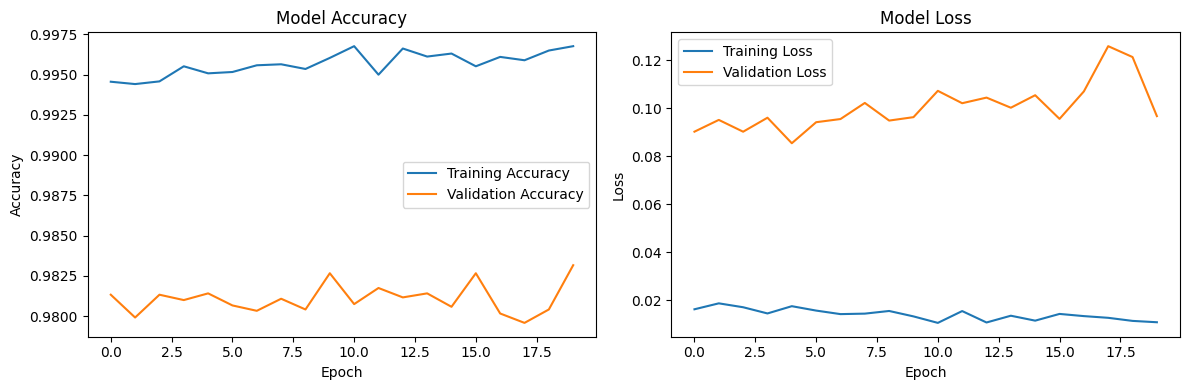

In [ ]:
# Plot training history
plt.figure(figsize=(12, 4))

# accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

#  loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 782us/step


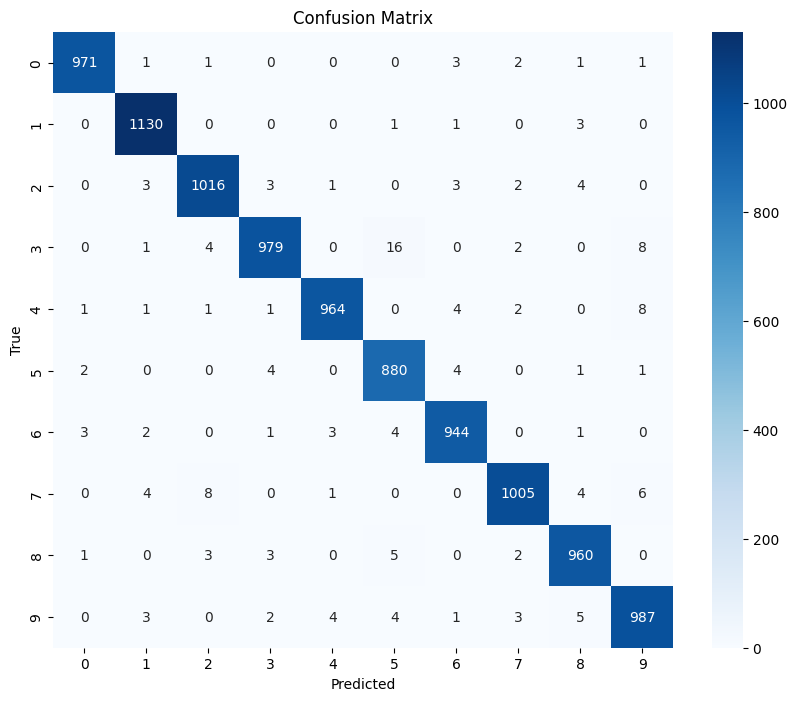


Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       980
           1       0.99      1.00      0.99      1135
           2       0.98      0.98      0.98      1032
           3       0.99      0.97      0.98      1010
           4       0.99      0.98      0.99       982
           5       0.97      0.99      0.98       892
           6       0.98      0.99      0.98       958
           7       0.99      0.98      0.98      1028
           8       0.98      0.99      0.98       974
           9       0.98      0.98      0.98      1009

    accuracy                           0.98     10000
   macro avg       0.98      0.98      0.98     10000
weighted avg       0.98      0.98      0.98     10000



In [30]:
# Make predictions
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

# Display confusion matrix
cm = confusion_matrix(y_test, y_pred_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Print classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred_classes))

In [33]:
# Create DataFrame with test data and predictions
test_df = pd.DataFrame(X_test.reshape(X_test.shape[0], -1))  # Flatten the image data
test_df['true_label'] = y_test
test_df['predicted_label'] = y_pred_classes
display(test_df.head())


,0,1,2,3,4,5,6,7,8,9,...,776,777,778,779,780,781,782,783,true_label,predicted_label
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7,7
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2,2
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,1
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4,4


In [34]:
# Save test results to CSV file
test_df.to_csv('test_results.csv', index=False)


## Conclusion


## Conclusion
Based on the model's performance metrics (98% accuracy), this is a successful deep learning model for digit classification using the MNIST dataset. The confusion matrix and classification report show strong performance across all digit classes, with most predictions falling on the diagonal of the confusion matrix indicating correct classifications. The model architecture, consisting of convolutional layers followed by dense layers with dropout for regularization, proved effective at learning the important features for digit recognition. The test results and predictiosn have been saved for reference, and the model demonstrates good generalization capabilities on unseen data. This project successfully demonstrates the application of a supervised learning model for image classification tasks.
